# Active Learning

Now that the data is preprocessed we can start with our actual experiments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Different classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn import pipeline, preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split, StratifiedKFold
from sklearn.ensemble import BaggingClassifier
from skactiveml.pool import UncertaintySampling, QueryByCommittee
from skactiveml.classifier import SklearnClassifier
from skactiveml.visualization import plot_decision_boundary, plot_utilities
from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from skactiveml.pool import RandomSampling, UncertaintySampling, ProbabilisticAL, CostEmbeddingAL, EpistemicUncertaintySampling

First we need to read in the dataframe where we categorize the target in numbers and get the input features and labels

In [2]:
#read in dataframe
data = pd.read_csv('dataset_1.csv')

#define the target and categorize it in numbers
target = 'PROFILE'
profile_options = np.unique(data['PROFILE'])
for index, profile in enumerate(profile_options):
    data.loc[data['PROFILE'] == profile,'PROFILE'] = index

#then get your input features and labels
X = np.array(data.drop(target, axis=1).values.tolist())
y_true = np.array(data[target]).astype('int')

Now we have extracted our features and labels and we can start our little experiment. The experiment goes as follows:

1) First we apply cross-validation on the classifier without tuning the hyperparameters.

2) We first just get a model and accuracy for the classifier without tuning the hyperparameters. 

3) Then we tune the hyperparameters of our classifier with the nested cross validation grid search.

4) Then we split out data into a training set and a test set.

5) We apply the active learning algorithm for different active learning methods by using a batch size of 100 for each active learning cycle. Then we run the algorithm so that after a certain amount of cycles we get to the training set. Then we compare these results for every active learning method to the classifier without using active learning. The model architecture and hyperparameters are all the same for every method.

6) We do this for both the classifier with and without tuning the hyperparameters.

Now that our experiment is thought through, we can start

### 1-2) Applying cross-validation on the classifier without tuning the hyperparameters

In [3]:
def class_accs(y_pred, y_true):
    acc0 = ((y_pred == y_true) & (y_true == 0)).sum() / (y_true == 0).sum()
    acc1 = ((y_pred == y_true) & (y_true == 1)).sum() / (y_true == 1).sum()
    return acc0, acc1

def balanced_accuracy(y_pred, y_test):
    acc0, acc1 = class_accs(y_pred, y_test)
    return (acc0 + acc1) / 2

def cross_validation(X, y, folds, clf):
    skf = StratifiedKFold(n_splits=folds)
    bal_accs = []
    for i, (train_index, test_index) in enumerate(skf.split(X,y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        bal_acc = balanced_accuracy(y_pred, y_test)
        bal_accs.append(bal_acc)
    print(f"Avg balanced accuracy: {np.mean(bal_accs):.3f}")
    print()

In [4]:
print('Decision Tree')
clf = pipeline.Pipeline([('sc', StandardScaler()), 
                         ('tree', DecisionTreeClassifier())])
cross_validation(X, y_true, 5, clf)

Decision Tree
Avg balanced accuracy: 0.751



### 3) Tuning the Hyperparameters
TO DO: normaal de nested_cv gebruiken maar kan nog geen best parameters printen

In [5]:
def grid_search(X, y, model, p_grid):
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    clf = GridSearchCV(estimator=model, param_grid=p_grid, scoring="balanced_accuracy", cv=cv)
    clf.fit(X, y)
    print(f"Best score: {clf.best_score_:.4f}")
    print(f"Best params: {clf.best_params_}")
    return clf.best_params_
    
def nested_cv(X, y, model, p_grid):
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    
    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X, y, cv=outer_cv)
    return nested_score.mean()

In [6]:
print("Decision Tree")
clf = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=0))
best_param_dt = grid_search(X, y_true, clf, {"decisiontreeclassifier__criterion": ["gini", "entropy"], "decisiontreeclassifier__max_depth": [3, 4, 5, None]})

Decision Tree
Best score: 0.7754
Best params: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': None}


### 4) Splitsing in Training and Testing set

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y_true,test_size = 0.25)

In [8]:
print('Length of the training set: '+str(len(X_train)))

Length of the training set: 14496


### 5) Apply Active Learning
Daarvoor normaliseren we eerst de data

In [9]:
print(X)

[[39. 52. 34. ... 69. 65. 73.]
 [28. 44. 16. ... 41. 40. 76.]
 [74. 36. 41. ... 52. 77. 66.]
 ...
 [32. 50. 22. ... 61. 81. 75.]
 [ 0. 96. 69. ... 64. 68. 68.]
 [51. 24. 36. ... 63. 61. 87.]]


In [10]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
print(X_scaled)

[[ 0.05935262  0.37752724 -0.14581716 ...  0.28598535 -0.16367699
   0.40363388]
 [-0.43264839  0.01919316 -1.02185322 ... -1.72329305 -1.92598189
   0.6124145 ]
 [ 1.62481036 -0.33914093  0.19486353 ... -0.93393368  0.68222937
  -0.08352089]
 ...
 [-0.25373893  0.28794372 -0.7298412  ... -0.28809419  0.96419815
   0.54282096]
 [-1.68501458  2.34836472  1.55758629 ... -0.07281436  0.0477996
   0.05566619]
 [ 0.59608099 -0.87664206 -0.04847982 ... -0.14457431 -0.44564577
   1.37794343]]


In [11]:
def ActiveLearning_UncertaintySampling(X, y_true, n_cycles, batch_size, qs, qs_name, clf, clf_name):
    y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
    clf.fit(X, y)
    accuracies = []
    cycle = []
    for c in range(n_cycles):
        query_idx = qs.query(X=X, y=y, clf=clf, batch_size=batch_size)
        y[query_idx] = y_true[query_idx]
        clf.fit(X, y)
        
        unlbld_idx = unlabeled_indices(y)
        lbld_idx = labeled_indices(y)
        accuracies.append(clf.score(X,y_true))
        cycle.append(c*batch_size)
    return cycle, accuracies

def ActiveLearning_RandomSampling(X, y_true, n_cycles, batch_size, qs, qs_name, clf, clf_name):
    y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
    clf.fit(X, y)
    accuracies = []
    cycle = []
    for c in range(n_cycles):
        query_idx = qs.query(X=X, y=y, batch_size=batch_size)
        y[query_idx] = y_true[query_idx]
        clf.fit(X, y)
        
        unlbld_idx = unlabeled_indices(y)
        lbld_idx = labeled_indices(y)
        accuracies.append(clf.score(X,y_true))
        cycle.append(c*batch_size)
    return cycle, accuracies

def ActiveLearning_QueryByCommittee(X, y_true, n_cycles, batch_size, qs, qs_name, clf, clf_name, committee_size):
    """
    The query-by-committee algorithm involves maintaining a committee of models which are all trained on the 
    current labeled set L, but representing competing hypotheses. Each committee member is allowed to vote on 
    the labeling of the query candidates. The most informative query is considered to be the instance about 
    which they most disagree.
    """
    
    y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
    clf.fit(X, y)
    accuracies = []
    cycle = []
    
    ensemble_bagging = SklearnClassifier(estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion = 'entropy'), n_estimators = committee_size), classes=np.unique(y_true))
                                        
    for c in range(n_cycles):
        query_idx = qs.query(X=X, y=y, ensemble=ensemble_bagging, batch_size=batch_size)
        y[query_idx] = y_true[query_idx]
        ensemble_bagging.fit(X, y)
        
        unlbld_idx = unlabeled_indices(y)
        lbld_idx = labeled_indices(y)
        accuracies.append(ensemble_bagging.score(X,y_true))
        cycle.append(c*batch_size)
    return cycle, accuracies

def plot_AL(cycle, accuracies, qs_name, clf_name):
    plt.plot(cycle, accuracies, label = qs_name)
    plt.xlabel('Labeled samples')
    plt.ylabel('Accuracy')
    plt.title(clf_name)
    plt.legend()
    plt.show()

Decision Tree


/home/silke/miniconda3/envs/ml-practica/lib/python3.10/site-packages/skactiveml/classifier/_wrapper.py:320: UserWarning: The 'base_estimator' could not be fitted because of 'There is no labeled data.'. Therefore, the class labels of the samples are counted and will be used to make predictions. The class label distribution is `_label_counts=[0, 0, 0, 0, 0, 0]`.
  warnings.warn(
/home/silke/miniconda3/envs/ml-practica/lib/python3.10/site-packages/skactiveml/classifier/_wrapper.py:320: UserWarning: The 'base_estimator' could not be fitted because of 'There is no labeled data.'. Therefore, the class labels of the samples are counted and will be used to make predictions. The class label distribution is `_label_counts=[0, 0, 0, 0, 0, 0]`.
  warnings.warn(
/home/silke/miniconda3/envs/ml-practica/lib/python3.10/site-packages/skactiveml/classifier/_wrapper.py:219: UserWarning: Since the 'base_estimator' could not be fitted when calling the `fit` method, the class label distribution`_label_count

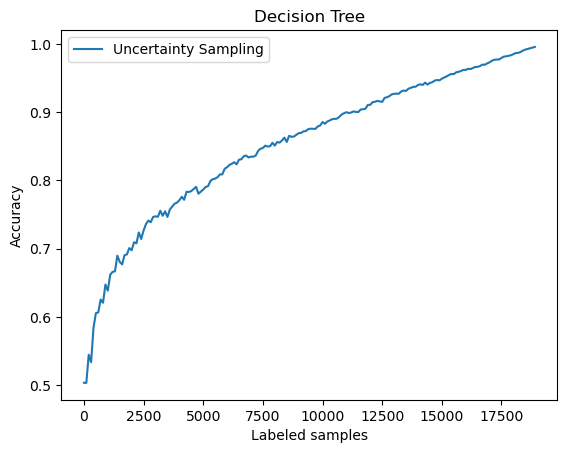

In [12]:
print('Decision Tree')
clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
clf_name = 'Decision Tree'
qs = UncertaintySampling(method='entropy')
qs_name = 'Uncertainty Sampling'
cycle, accuracies = ActiveLearning_UncertaintySampling(X_scaled, y_true, 190, 100, qs, qs_name, clf, clf_name)
plot_AL(cycle, accuracies, qs_name, clf_name)

In [ ]:
clf_name = 'Decision Tree'
colors = ['blue', 'red', 'green']

clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_RandomSampling(X_scaled, y_true, 190, 100, RandomSampling(), 'Random sampling', clf, clf_name)
plt.plot(cycle, accuracies, color = 'red', label = 'Random')
clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_UncertaintySampling(X_scaled, y_true, 190, 100, UncertaintySampling(method='entropy'), 'Uncertainty Sampling', clf, clf_name)
plt.plot(cycle, accuracies, color = 'blue', label = 'Uncertainty')
clf = SklearnClassifier(DecisionTreeClassifier(criterion = 'entropy'), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_QueryByCommittee(X_scaled, y_true, 190, 100, QueryByCommittee(), 'Query by committee', clf, clf_name, 3)
plt.plot(cycle, accuracies, color = 'green', label = 'QBC')

plt.xlabel('Labeled samples')
plt.ylabel('Accuracy')
plt.title(clf_name)
plt.legend()
plt.show()

/home/silke/miniconda3/envs/ml-practica/lib/python3.10/site-packages/skactiveml/classifier/_wrapper.py:320: UserWarning: The 'base_estimator' could not be fitted because of 'There is no labeled data.'. Therefore, the class labels of the samples are counted and will be used to make predictions. The class label distribution is `_label_counts=[0, 0, 0, 0, 0, 0]`.
  warnings.warn(
/home/silke/miniconda3/envs/ml-practica/lib/python3.10/site-packages/skactiveml/classifier/_wrapper.py:320: UserWarning: The 'base_estimator' could not be fitted because of 'There is no labeled data.'. Therefore, the class labels of the samples are counted and will be used to make predictions. The class label distribution is `_label_counts=[0, 0, 0, 0, 0, 0]`.
  warnings.warn(
/home/silke/miniconda3/envs/ml-practica/lib/python3.10/site-packages/skactiveml/classifier/_wrapper.py:320: UserWarning: The 'base_estimator' could not be fitted because of 'There is no labeled data.'. Therefore, the class labels of the sam